# Demo - Evaluation - SVGP (PyTorch)

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)


from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.gp_torch import add_model_args, get_inducing_points
from losses.gp_torch import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizers.gp_torch import add_optimizer_args
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.argparse import add_argparse_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Arguments

In [3]:
# ige/nerf4ssh/akq2iv1z
# ige/gps4ssh/fsixlup6
wandb_id = "fsixlup6"
entity = "ige"
project = "gps4ssh"
resume = True
mode = "online"

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=wandb_id,
    mode=mode,
    project=project,
    entity=entity,
    resume=resume,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
2022-06-06 16:59:32.615537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 16:59:32.615580: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
args = wandb.config
args.train_data_dir = "/home/johnsonj/data/dc_2021/raw/train"
args.ref_data_dir = "/home/johnsonj/data/dc_2021/raw/ref"
args.test_data_dir = "/home/johnsonj/data/dc_2021/raw/test"

### Load Data

In [6]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 16.11it/s]


CPU times: user 436 ms, sys: 896 ms, total: 1.33 s
Wall time: 1.85 s


In [7]:
# preprocess data
data = preprocess_data(data, args)

In [8]:
# feature transformation
data, scaler = feature_transform(data, args)

In [9]:
data.attrs["input_cols"]

['longitude', 'latitude', 'time']

In [10]:
# split data
xtrain = data[data.attrs["input_cols"]].values
ytrain = data[data.attrs["output_cols"]].values.squeeze()

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]

if args.smoke_test:
    
    rng = np.random.RandomState(args.split_seed)
    idx = rng.choice(np.arange(args.n_train), size=2_000)
    xtrain = xtrain[idx]
    ytrain = ytrain[idx]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
    }
)

In [11]:
xtrain.shape, ytrain.shape

((1790094, 3), (1790094,))

### Dataset

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
class PointsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [14]:
# initialize dataset
ds_train = PointsDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
# initialize dataloader
# initialize dataloader
dl_train = DataLoader(
    ds_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    pin_memory=True,
    num_workers=args.num_workers
)

### Model

In [15]:
import gpytorch

In [16]:
class SVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, kernel, inducing_points, variational_dist):
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=args.learn_inducing
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
from models.gp_torch import get_kernel, get_likelihood, get_variational_dist

In [18]:
args.n_inducing, xtrain.shape,

(2000, (1790094, 3))

In [19]:
# get inducing points
# inducing_points = get_inducing_points(xtrain, args)
inducing_points = xtrain[:args.n_inducing]

# get kernel
kernel = get_kernel(args)

# get variational dist
variational_dist = get_variational_dist(torch.Tensor(inducing_points), args)

# initialize model
model = SVGPModel(
    kernel=kernel,
    variational_dist=variational_dist,
    inducing_points=torch.Tensor(inducing_points)
)

# initialize likelihood
likelihood = get_likelihood(args)

In [20]:
# if torch.cuda.is_available() and args.gpus > 0:
#     model = model.cuda()
#     likelihood = likelihood.cuda()

### Training

In [21]:
# variational_ngd_optimizer = gpytorch.optim.NGD(
#     model.variational_parameters(), 
#     num_data=ytrain.shape[0], 
#     lr=args.learning_rate_ng
# )

# hyperparameter_optimizer = torch.optim.Adam([
#     {'params': model.hyperparameters()},
#     {'params': likelihood.parameters()},
# ], lr=args.learning_rate)

In [22]:
# model.train()
# likelihood.train()
# mll = get_loss_fn(likelihood, model, ytrain.shape[0], args=args)

In [23]:
# epochs_iter = tqdm.notebook.tqdm(range(100), desc="Epoch")

# for i in epochs_iter:
#     minibatch_iter = tqdm.notebook.tqdm(dl_train, desc="Minibatch", leave=False)

#     for j, (x_batch, y_batch) in enumerate(minibatch_iter):
#         ### Perform NGD step to optimize variational parameters
#         variational_ngd_optimizer.zero_grad()
#         hyperparameter_optimizer.zero_grad()
#         output = model(x_batch)
#         loss = -mll(output, y_batch)
#         minibatch_iter.set_postfix(loss=loss.item())
#         loss.backward()
#         variational_ngd_optimizer.step()
#         hyperparameter_optimizer.step()
#         wandb.log({"nll_loss": loss.item(), "batch":j , "epoch":i})
        

### Save models

In [24]:
# # objects
# path_scaler = "scaler.pickle"
# path_model = "model.pickle"

# # models to save
# torch.save(model.state_dict(), path_model)
# save_object(scaler, path_scaler)

# # save with wandb
# wandb.save(str(path_scaler))
# wandb.save(str(path_model))

### Load Models (Optional)

In [25]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    "model.pickle"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [26]:
# model = load_object("./model.pickle")
scaler = load_object("./scaler.pickle")

In [27]:
state_dict = torch.load("./model.pickle", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

### PostProcessing

In [28]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,967980.000000,967980.000000,967980.000000
mean,300.000000,38.100000,213.000000
std,2.943922,3.001668,105.366083
min,295.000000,33.000000,31.000000
25%,297.400000,35.550000,122.000000
50%,300.000000,38.100000,213.000000
75%,302.600000,40.650000,304.000000
max,305.000000,43.200000,395.000000


In [29]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

['longitude', 'latitude', 'time']


,longitude,latitude,time,vtime
count,967980.000000,967980.000000,967980.000000,967980.000000
mean,-0.176144,0.292042,0.050524,213.000000
std,0.348097,0.383708,0.852070,105.366083
min,-0.767357,-0.359899,-1.421267,31.000000
25%,-0.483575,-0.033928,-0.685372,122.000000
50%,-0.176144,0.292042,0.050524,213.000000
75%,0.131287,0.618013,0.786419,304.000000
max,0.415069,0.943984,1.522314,395.000000


In [30]:
df_grid.describe()

,longitude,latitude,vtime
count,967980.000000,967980.000000,967980.000000
mean,300.000000,38.100000,213.000000
std,2.943922,3.001668,105.366083
min,295.000000,33.000000,31.000000
25%,297.400000,35.550000,122.000000
50%,300.000000,38.100000,213.000000
75%,302.600000,40.650000,304.000000
max,305.000000,43.200000,395.000000


In [31]:
df_pred = df_pred[df_pred.attrs["input_cols"]]

In [32]:
df_pred.head()

,longitude,latitude,time
0,-0.767357,-0.359899,-1.421267
1,-0.767357,-0.359899,-1.413180
2,-0.767357,-0.359899,-1.405093
3,-0.767357,-0.359899,-1.397006
4,-0.767357,-0.359899,-1.388919


In [33]:
xtest = df_pred.values

In [34]:
from torch.utils.data import TensorDataset

In [35]:
args.eval_batch_size

10000

In [36]:
# initialize dataset
xtest = torch.Tensor(xtest)
if torch.cuda.is_available():
    xtest = xtest.cuda()

ds_test = TensorDataset(xtest)
# initialize dataloader
dl_test = DataLoader(
    ds_test, 
    batch_size= 300,# args.eval_batch_size, 
    shuffle=False, 
    pin_memory=True
)

In [37]:


model.eval()
likelihood.eval()
means = torch.tensor([])
variances = torch.tensor([])

# t0 = time.time()

with torch.no_grad():
    for x_batch in tqdm.tqdm(dl_test):
        preds = model(x_batch[0])
        means = torch.cat([means, preds.mean.cpu()])
        variances = torch.cat([variances, preds.variance.cpu()])


  0%|          | 0/3227 [00:00<?, ?it/s]/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/gpytorch/variational/natural_variational_distribution.py:76: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  return eye.triangular_solve(A, upper=upper).solution
100%|██████████| 3227/3227 [08:41<00:00,  6.18it/s]


In [38]:
df_grid["pred"] = means.numpy()
df_grid["var"] = variances.numpy()

In [39]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

In [40]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/si

In [41]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    vtime      (latitude, longitude, time) float64 31.0 32.0 ... 394.0 395.0
    pred       (latitude, longitude, time) float32 0.1355 0.1371 ... 0.2244
    var        (latitude, longitude, time) float32 0.0007608 ... 0.0006699
    ssh        (latitude, longitude, time) float64 0.7352 0.7368 ... 0.04809

In [42]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

RMSE (Mean): 0.117
RMSE (Std): 0.036
NRMSE (Mean): 0.803
NRMSE (Std): 0.110
CPU times: user 472 ms, sys: 60 ms, total: 532 ms
Wall time: 699 ms


In [43]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

wandb.log(
    {
        "resolved_scale": psd_metrics.resolved_scale,
    }
)

Resolved Scale: 224.069 (km)


### Figures

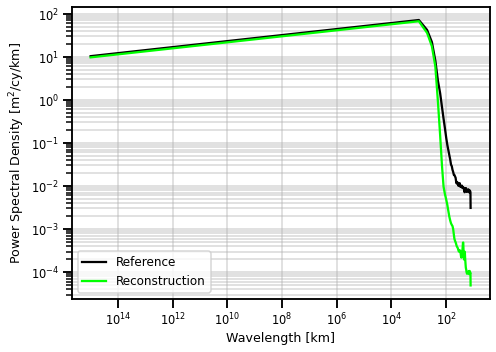

In [44]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

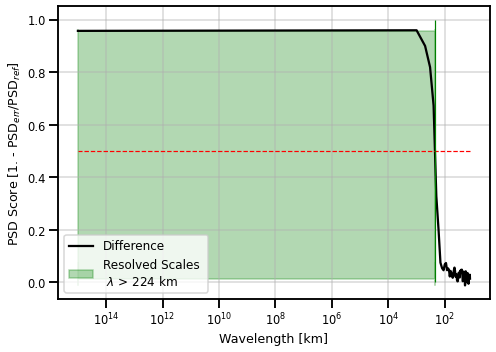

In [45]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [118]:
wandb.finish()

In [42]:
# save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [43]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [44]:
# create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

<!-- ![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif) -->

In [45]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [46]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [47]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [48]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [49]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [50]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [51]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [52]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [53]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [54]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )